In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,data.shape[3],1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

def resize_par(data, factor):
    test =  np.zeros((data.shape[0], data.shape[1],data.shape[2],data.shape[3]//factor))
    print(data.shape, test.shape)
    for i in range(6):
        test[:,i,:,:] = downscale_local_mean(data[:,i,:,:], (1,1,factor))
    return test


In [2]:
plate = np.load('../../real_filtered.npy')[:12000]
print(plate.shape)

(12000, 6, 16, 2048)


In [3]:
%matplotlib inline
NUM_SAMPLES = 10000

print(plate.shape)
print("Creating True")
data = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=10, factor =1)
print(data.shape)
data = resize_par(data, factor=8)
data = combine(load_data_ED(data))
print(data.shape)

print("Creating False")
false_data = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=10))
false_data = resize_par(false_data, factor=8)
false_data = load_data_ED(false_data)


print("Creating True")
true_data_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_1 = resize_par(true_data_1, factor=8)
true_data_1 = load_data_ED(true_data_1)

true_data_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_2 = resize_par(true_data_2, factor=8)
true_data_2 = load_data_ED(true_data_2)

true_data = np.concatenate((true_data_1,true_data_2),axis=0)
print(true_data.shape)

del true_data_1,true_data_2
gc.collect()

(12000, 6, 16, 2048)
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)
(60000, 6, 16, 256)
Creating True
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(60000, 6, 16, 256, 1)


31174

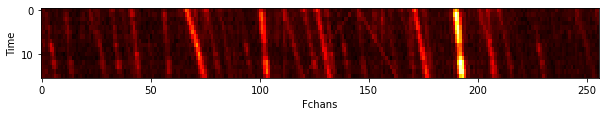

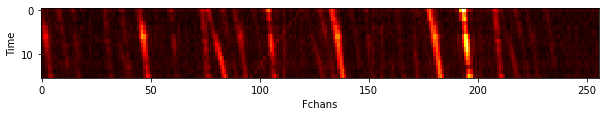

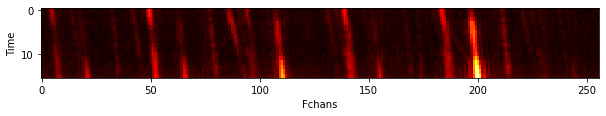

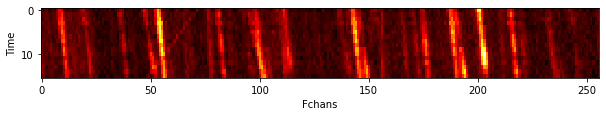

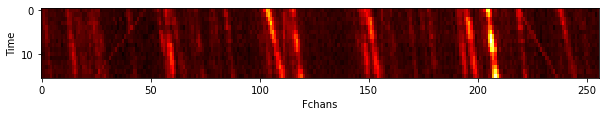

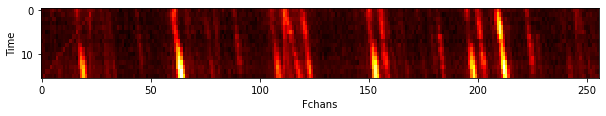

In [4]:
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[0,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

In [5]:
NUM_SAMPLES = 1000

print(plate.shape)
print("Creating True")
data_test = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=10, factor =1)
data_test = resize_par(data_test, factor=8)
data_test = combine(load_data_ED(data_test))

print("Creating False")
false_data_test = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=10))
false_data_test = resize_par(false_data_test, factor=8)
false_data_test = load_data_ED(false_data_test)


print("Creating True")
true_data_test_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_test_1 = resize_par(true_data_test_1, factor=8)
true_data_test_1 = load_data_ED(true_data_test_1)

true_data_test_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_test_2 = resize_par(true_data_test_2, factor=8)
true_data_test_2 = load_data_ED(true_data_test_2)


true_data_test = np.concatenate((true_data_test_1,true_data_test_2),axis=0)
print(true_data_test.shape)
del true_data_test_1,true_data_test_2
gc.collect()

(12000, 6, 16, 2048)
Creating True
(1000, 6, 16, 2048) (1000, 6, 16, 256)
(1000, 6, 16, 256)
Creating False
(6000, 6, 16, 2048) (6000, 6, 16, 256)
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)


16090

In [89]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,  **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        alpha=10
        beta=2
        self.alpha = alpha
        self.beta = beta
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(10*true_loss+false_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(10*true_loss+false_loss)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result()
        }

In [90]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [91]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [92]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [93]:
def build_model():
    latent_dim = 8
    dens_lay = 512
    kernel = (3,3)
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001))(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=l1(0.001))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var" , activity_regularizer=l1(0.001))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001))(latent_inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(1* 16 * 256, activation="relu", activity_regularizer=l1(0.001))(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Reshape((1,16, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 8, 128, 16)   160         in

In [94]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.hdf5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

history = model.fit(x = [data, true_data, false_data], y= data[:,:,:,:], epochs=300, batch_size=1000, 
          validation_data=([data_test, true_data_test, false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/300
60/60 [==============================] - 59s 526ms/step - loss: 4897.0822 - reconstruction_loss: 2614.1021 - kl_loss: 6.2850 - false_loss: 30.7881 - true_loss: 18.7404 - val_loss: 4175.3633 - val_reconstruction_loss: 2508.6060 - val_kl_loss: 6.8980 - val_false_loss: 15.9978 - val_true_loss: 14.9298
Epoch 2/300
60/60 [==============================] - 20s 335ms/step - loss: 4169.4486 - reconstruction_loss: 2488.5239 - kl_loss: 7.5521 - false_loss: 19.4905 - true_loss: 15.8809 - val_loss: 4160.7080 - val_reconstruction_loss: 2489.7139 - val_kl_loss: 7.4006 - val_false_loss: 15.7903 - val_true_loss: 14.9829
Epoch 3/300
60/60 [==============================] - 21s 350ms/step - loss: 4141.2776 - reconstruction_loss: 2469.4714 - kl_loss: 7.9810 - false_loss: 17.9923 - true_loss: 15.5141 - val_loss: 4145.8252 - val_reconstruction_loss: 2475.7224 - val_kl_loss: 7.5749 - val_false_loss: 15.9530 - val_true_loss: 14.9542
Epoch 4/300
60/60 [==============================] - 23s 379ms/s

60/60 [==============================] - 22s 368ms/step - loss: 3177.8565 - reconstruction_loss: 2510.0369 - kl_loss: 37.3129 - false_loss: 12.5343 - true_loss: 12.9172 - val_loss: 3879.5864 - val_reconstruction_loss: 2462.6287 - val_kl_loss: 17.4154 - val_false_loss: 11.6561 - val_true_loss: 12.6557
Epoch 28/300
60/60 [==============================] - 22s 367ms/step - loss: 3162.7051 - reconstruction_loss: 2509.9561 - kl_loss: 37.4885 - false_loss: 12.2869 - true_loss: 12.6411 - val_loss: 3856.8794 - val_reconstruction_loss: 2464.0066 - val_kl_loss: 18.1457 - val_false_loss: 11.5285 - val_true_loss: 12.4130
Epoch 29/300
60/60 [==============================] - 22s 368ms/step - loss: 3155.6657 - reconstruction_loss: 2508.4333 - kl_loss: 37.6733 - false_loss: 12.0529 - true_loss: 12.3817 - val_loss: 3838.3696 - val_reconstruction_loss: 2465.3152 - val_kl_loss: 18.8062 - val_false_loss: 11.2643 - val_true_loss: 12.2280
Epoch 30/300
60/60 [==============================] - 22s 368ms/step

60/60 [==============================] - 22s 366ms/step - loss: 3018.2622 - reconstruction_loss: 2503.9067 - kl_loss: 35.9935 - false_loss: 8.7011 - true_loss: 8.7449 - val_loss: 3589.0706 - val_reconstruction_loss: 2481.0073 - val_kl_loss: 26.5201 - val_false_loss: 8.2480 - val_true_loss: 9.7254
Epoch 54/300
60/60 [==============================] - 22s 367ms/step - loss: 3034.7751 - reconstruction_loss: 2503.7478 - kl_loss: 35.5482 - false_loss: 8.6283 - true_loss: 8.6576 - val_loss: 3585.1833 - val_reconstruction_loss: 2481.4487 - val_kl_loss: 26.6553 - val_false_loss: 8.1636 - val_true_loss: 9.6879
Epoch 55/300
60/60 [==============================] - 22s 371ms/step - loss: 3036.1491 - reconstruction_loss: 2504.4133 - kl_loss: 35.2268 - false_loss: 8.5595 - true_loss: 8.5743 - val_loss: 3579.7668 - val_reconstruction_loss: 2481.7876 - val_kl_loss: 26.8305 - val_false_loss: 8.0841 - val_true_loss: 9.6348
Epoch 56/300
60/60 [==============================] - 22s 368ms/step - loss: 300

60/60 [==============================] - 22s 366ms/step - loss: 3071.6415 - reconstruction_loss: 2596.6714 - kl_loss: 37.7205 - false_loss: 7.2921 - true_loss: 7.1142 - val_loss: 3508.7224 - val_reconstruction_loss: 2493.3970 - val_kl_loss: 29.8326 - val_false_loss: 7.1211 - val_true_loss: 8.8445
Epoch 80/300
60/60 [==============================] - 22s 362ms/step - loss: 3066.6739 - reconstruction_loss: 2595.7292 - kl_loss: 37.3935 - false_loss: 7.2537 - true_loss: 7.0692 - val_loss: 3507.7017 - val_reconstruction_loss: 2494.5803 - val_kl_loss: 29.9196 - val_false_loss: 7.0820 - val_true_loss: 8.8246
Epoch 81/300
60/60 [==============================] - 22s 365ms/step - loss: 3043.9158 - reconstruction_loss: 2539.3572 - kl_loss: 36.4210 - false_loss: 7.2193 - true_loss: 7.0260 - val_loss: 3506.2400 - val_reconstruction_loss: 2494.6909 - val_kl_loss: 29.9842 - val_false_loss: 7.0379 - val_true_loss: 8.8120
Epoch 82/300
60/60 [==============================] - 22s 364ms/step - loss: 298

60/60 [==============================] - 22s 369ms/step - loss: 2890.5594 - reconstruction_loss: 2445.1646 - kl_loss: 38.5458 - false_loss: 6.5557 - true_loss: 6.2110 - val_loss: 3461.4441 - val_reconstruction_loss: 2486.7002 - val_kl_loss: 31.5423 - val_false_loss: 6.4416 - val_true_loss: 8.4724
Epoch 106/300
60/60 [==============================] - 22s 364ms/step - loss: 2891.9098 - reconstruction_loss: 2449.3625 - kl_loss: 38.2587 - false_loss: 6.5328 - true_loss: 6.1831 - val_loss: 3461.4729 - val_reconstruction_loss: 2486.2312 - val_kl_loss: 31.5770 - val_false_loss: 6.4119 - val_true_loss: 8.4797
Epoch 107/300
60/60 [==============================] - 23s 380ms/step - loss: 2895.9013 - reconstruction_loss: 2444.5139 - kl_loss: 38.3507 - false_loss: 6.5111 - true_loss: 6.1558 - val_loss: 3460.8408 - val_reconstruction_loss: 2485.7744 - val_kl_loss: 31.6247 - val_false_loss: 6.3859 - val_true_loss: 8.4796
Epoch 108/300
60/60 [==============================] - 22s 369ms/step - loss: 

60/60 [==============================] - 22s 365ms/step - loss: 2842.7750 - reconstruction_loss: 2443.5510 - kl_loss: 39.8633 - false_loss: 6.0621 - true_loss: 5.5984 - val_loss: 3429.4092 - val_reconstruction_loss: 2477.0146 - val_kl_loss: 32.8516 - val_false_loss: 6.0090 - val_true_loss: 8.2660
Epoch 132/300
60/60 [==============================] - 22s 366ms/step - loss: 2855.5189 - reconstruction_loss: 2445.0398 - kl_loss: 39.7066 - false_loss: 6.0456 - true_loss: 5.5778 - val_loss: 3428.4106 - val_reconstruction_loss: 2477.0894 - val_kl_loss: 32.8999 - val_false_loss: 6.0005 - val_true_loss: 8.2552
Epoch 133/300
60/60 [==============================] - 22s 365ms/step - loss: 2868.7101 - reconstruction_loss: 2447.1956 - kl_loss: 38.5577 - false_loss: 6.0302 - true_loss: 5.5581 - val_loss: 3427.2085 - val_reconstruction_loss: 2476.7788 - val_kl_loss: 32.9428 - val_false_loss: 5.9830 - val_true_loss: 8.2472
Epoch 134/300
60/60 [==============================] - 22s 366ms/step - loss: 

60/60 [==============================] - 22s 365ms/step - loss: 2818.6718 - reconstruction_loss: 2442.2422 - kl_loss: 40.6025 - false_loss: 5.7061 - true_loss: 5.1444 - val_loss: 3402.7949 - val_reconstruction_loss: 2470.7317 - val_kl_loss: 33.8930 - val_false_loss: 5.7235 - val_true_loss: 8.0704
Epoch 158/300
60/60 [==============================] - 22s 364ms/step - loss: 2845.7439 - reconstruction_loss: 2441.7229 - kl_loss: 40.0628 - false_loss: 5.6945 - true_loss: 5.1296 - val_loss: 3401.8457 - val_reconstruction_loss: 2470.5103 - val_kl_loss: 33.9326 - val_false_loss: 5.7178 - val_true_loss: 8.0629
Epoch 159/300
60/60 [==============================] - 22s 363ms/step - loss: 2839.4426 - reconstruction_loss: 2442.8354 - kl_loss: 39.9173 - false_loss: 5.6836 - true_loss: 5.1151 - val_loss: 3401.3145 - val_reconstruction_loss: 2470.3281 - val_kl_loss: 33.9635 - val_false_loss: 5.7050 - val_true_loss: 8.0601
Epoch 160/300
60/60 [==============================] - 22s 365ms/step - loss: 

60/60 [==============================] - 22s 363ms/step - loss: 2814.2324 - reconstruction_loss: 2440.9150 - kl_loss: 40.5195 - false_loss: 5.4472 - true_loss: 4.8062 - val_loss: 3384.0881 - val_reconstruction_loss: 2465.7922 - val_kl_loss: 34.6962 - val_false_loss: 5.5090 - val_true_loss: 7.9381
Epoch 184/300
60/60 [==============================] - 22s 364ms/step - loss: 2811.8142 - reconstruction_loss: 2440.4255 - kl_loss: 40.9171 - false_loss: 5.4378 - true_loss: 4.7946 - val_loss: 3383.4739 - val_reconstruction_loss: 2465.6174 - val_kl_loss: 34.7254 - val_false_loss: 5.4999 - val_true_loss: 7.9341
Epoch 185/300
60/60 [==============================] - 22s 363ms/step - loss: 2835.5150 - reconstruction_loss: 2452.1450 - kl_loss: 39.3308 - false_loss: 5.4286 - true_loss: 4.7829 - val_loss: 3382.8054 - val_reconstruction_loss: 2465.4739 - val_kl_loss: 34.7402 - val_false_loss: 5.4903 - val_true_loss: 7.9295
Epoch 186/300
60/60 [==============================] - 22s 364ms/step - loss: 

60/60 [==============================] - 22s 366ms/step - loss: 2787.2040 - reconstruction_loss: 2439.9727 - kl_loss: 41.3464 - false_loss: 5.2173 - true_loss: 4.5191 - val_loss: 3368.7405 - val_reconstruction_loss: 2461.8613 - val_kl_loss: 35.3498 - val_false_loss: 5.2985 - val_true_loss: 7.8320
Epoch 210/300
60/60 [==============================] - 22s 366ms/step - loss: 2789.0577 - reconstruction_loss: 2439.7070 - kl_loss: 41.5630 - false_loss: 5.2085 - true_loss: 4.5087 - val_loss: 3368.2922 - val_reconstruction_loss: 2461.7227 - val_kl_loss: 35.3707 - val_false_loss: 5.2903 - val_true_loss: 7.8293
Epoch 211/300
60/60 [==============================] - 22s 362ms/step - loss: 2822.2912 - reconstruction_loss: 2440.2703 - kl_loss: 40.4425 - false_loss: 5.2008 - true_loss: 4.4995 - val_loss: 3367.6892 - val_reconstruction_loss: 2461.5852 - val_kl_loss: 35.3937 - val_false_loss: 5.2829 - val_true_loss: 7.8249
Epoch 212/300
60/60 [==============================] - 22s 363ms/step - loss: 

60/60 [==============================] - 22s 362ms/step - loss: 2811.2091 - reconstruction_loss: 2439.8281 - kl_loss: 40.3966 - false_loss: 5.0254 - true_loss: 4.2883 - val_loss: 3356.1819 - val_reconstruction_loss: 2458.7012 - val_kl_loss: 35.9239 - val_false_loss: 5.1498 - val_true_loss: 7.7414
Epoch 236/300
60/60 [==============================] - 22s 363ms/step - loss: 2775.8908 - reconstruction_loss: 2439.3931 - kl_loss: 41.7751 - false_loss: 5.0185 - true_loss: 4.2805 - val_loss: 3355.6785 - val_reconstruction_loss: 2458.5955 - val_kl_loss: 35.9452 - val_false_loss: 5.1418 - val_true_loss: 7.7378
Epoch 237/300
60/60 [==============================] - 22s 365ms/step - loss: 2765.8052 - reconstruction_loss: 2439.4954 - kl_loss: 42.1888 - false_loss: 5.0107 - true_loss: 4.2719 - val_loss: 3355.0396 - val_reconstruction_loss: 2458.4878 - val_kl_loss: 35.9723 - val_false_loss: 5.1446 - val_true_loss: 7.7316
Epoch 238/300
60/60 [==============================] - 22s 363ms/step - loss: 

60/60 [==============================] - 22s 363ms/step - loss: 2884.9675 - reconstruction_loss: 2439.5620 - kl_loss: 40.3681 - false_loss: 4.8570 - true_loss: 4.0911 - val_loss: 3345.9905 - val_reconstruction_loss: 2456.2412 - val_kl_loss: 36.4052 - val_false_loss: 5.0320 - val_true_loss: 7.6662
Epoch 262/300
60/60 [==============================] - 22s 362ms/step - loss: 2763.9955 - reconstruction_loss: 2439.4744 - kl_loss: 41.9454 - false_loss: 4.8506 - true_loss: 4.0839 - val_loss: 3345.5610 - val_reconstruction_loss: 2456.1514 - val_kl_loss: 36.4234 - val_false_loss: 5.0252 - val_true_loss: 7.6631
Epoch 263/300
60/60 [==============================] - 22s 363ms/step - loss: 2764.4913 - reconstruction_loss: 2439.9165 - kl_loss: 42.0923 - false_loss: 4.8442 - true_loss: 4.0765 - val_loss: 3345.1157 - val_reconstruction_loss: 2456.0713 - val_kl_loss: 36.4422 - val_false_loss: 5.0263 - val_true_loss: 7.6590
Epoch 264/300
60/60 [==============================] - 22s 368ms/step - loss: 

60/60 [==============================] - 22s 363ms/step - loss: 2790.8778 - reconstruction_loss: 2440.0063 - kl_loss: 40.8757 - false_loss: 4.6977 - true_loss: 3.9153 - val_loss: 3334.2368 - val_reconstruction_loss: 2454.1978 - val_kl_loss: 36.8604 - val_false_loss: 4.8986 - val_true_loss: 7.5733
Epoch 288/300
60/60 [==============================] - 22s 363ms/step - loss: 2820.2332 - reconstruction_loss: 2439.6169 - kl_loss: 41.0211 - false_loss: 4.6931 - true_loss: 3.9106 - val_loss: 3333.7627 - val_reconstruction_loss: 2454.1267 - val_kl_loss: 36.8802 - val_false_loss: 4.8930 - val_true_loss: 7.5695
Epoch 289/300
60/60 [==============================] - 22s 364ms/step - loss: 2759.7469 - reconstruction_loss: 2439.8611 - kl_loss: 41.9259 - false_loss: 4.6875 - true_loss: 3.9046 - val_loss: 3333.3245 - val_reconstruction_loss: 2454.0554 - val_kl_loss: 36.8981 - val_false_loss: 4.8880 - val_true_loss: 7.5659
Epoch 290/300
60/60 [==============================] - 22s 361ms/step - loss: 

In [84]:
model.encoder.save("VAE-ENCODER_compressed_256v5.h5")
# model.decoder.save("VAE-DECODERv14.h5")

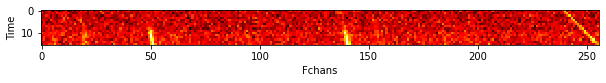

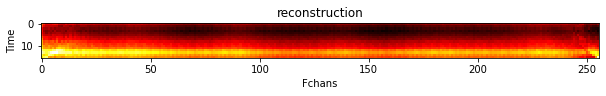

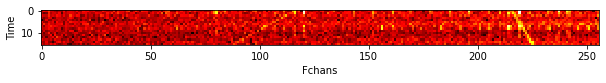

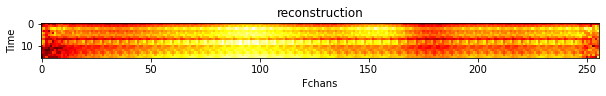

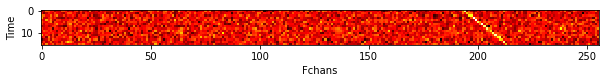

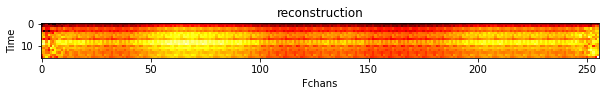

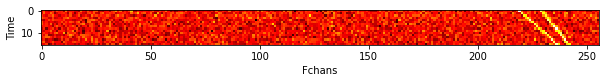

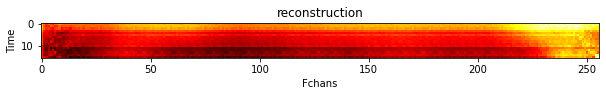

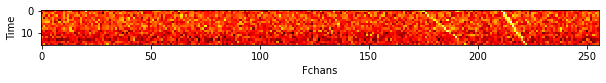

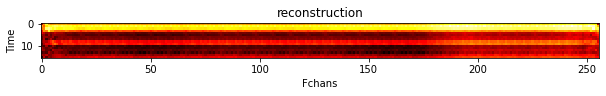

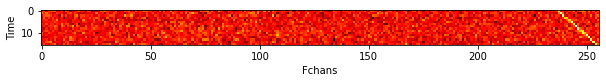

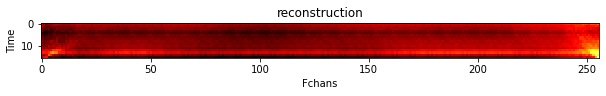

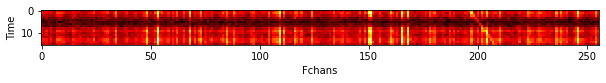

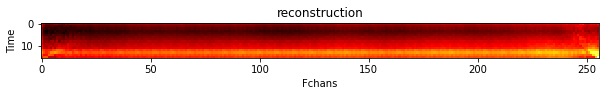

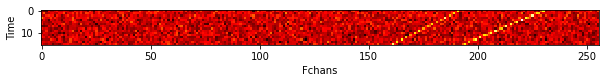

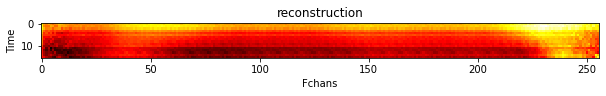

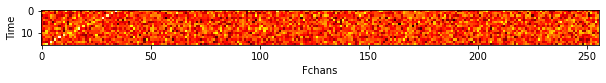

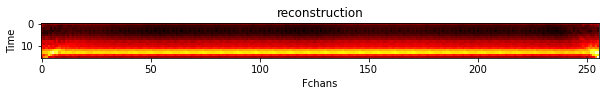

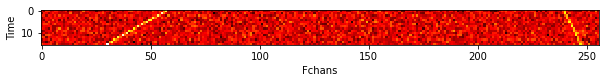

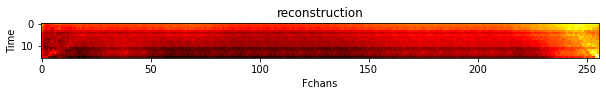

In [13]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
